In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')

In [54]:
df=pd.read_csv('PJME_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

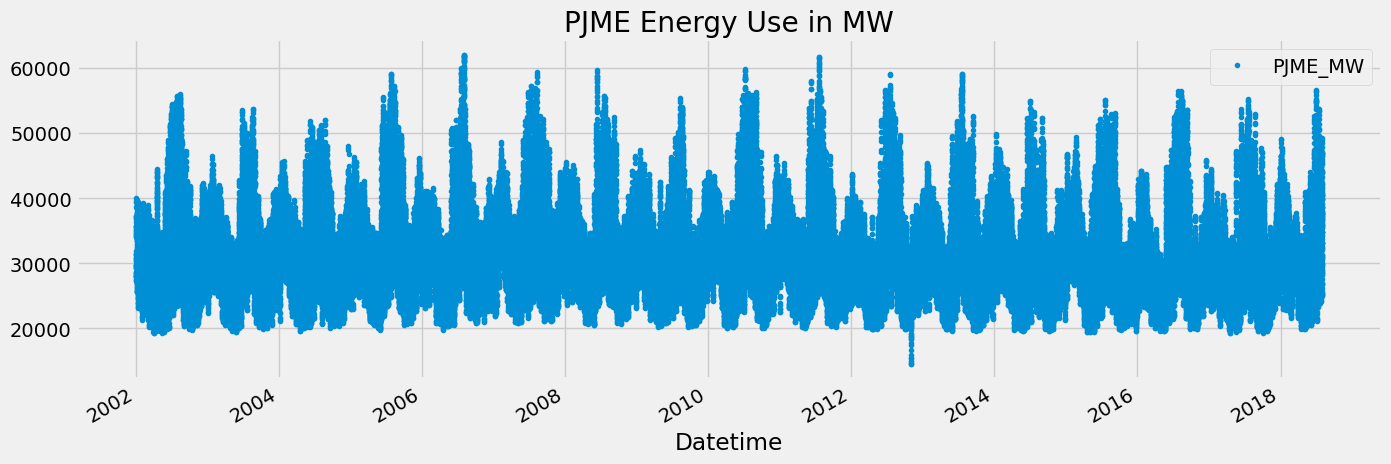

In [55]:
df.plot(style='.',figsize=(15,5),color=color_pal[0],title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

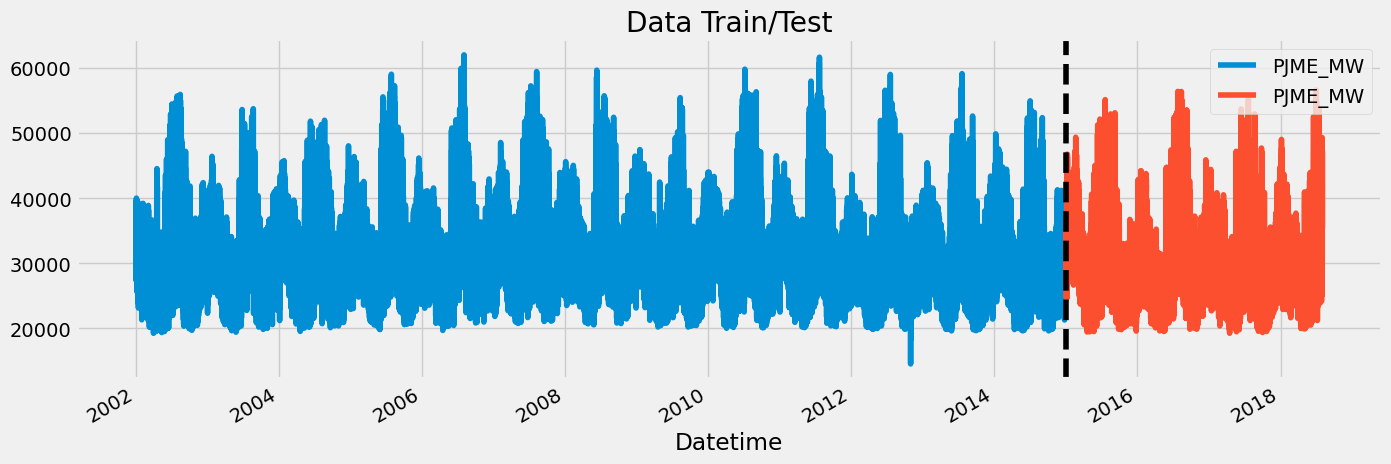

In [56]:
train=df.loc[df.index<'01-01-2015']
test=df.loc[df.index>='01-01-2015']

fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Set',color=color_pal[0],title='Data Train/Test')
test.plot(ax=ax,label='Test Set',color=color_pal[1])
ax.axvline('01-01-2015',color='black',ls='--')

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

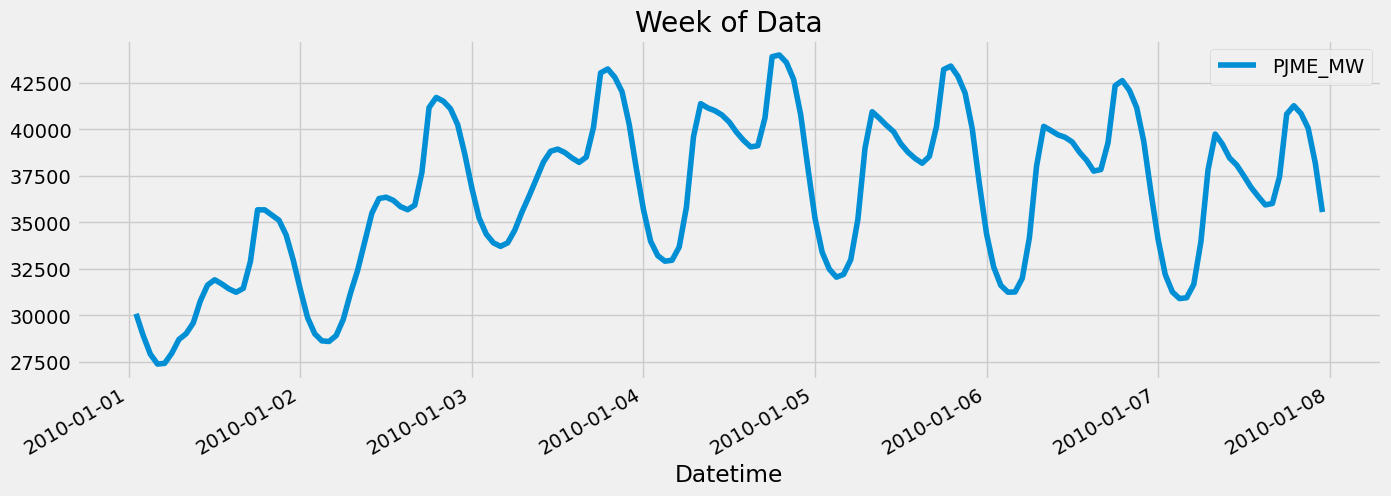

In [57]:
one_week=df.loc[(df.index >'01-01-2010') & (df.index <'01-08-2010')]
one_week.plot(title='Week of Data',figsize=(15,5))

# Feature Creation

In [58]:
df.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
      dtype='int32', name='Datetime', length=145366)

In [59]:
def feature_creator(df):
    """
    Create time series features based on time series index.
    """
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayodyear']=df.index.day_of_year
    return df
df=feature_creator(df)

# Visualise our Features/ Target relationship

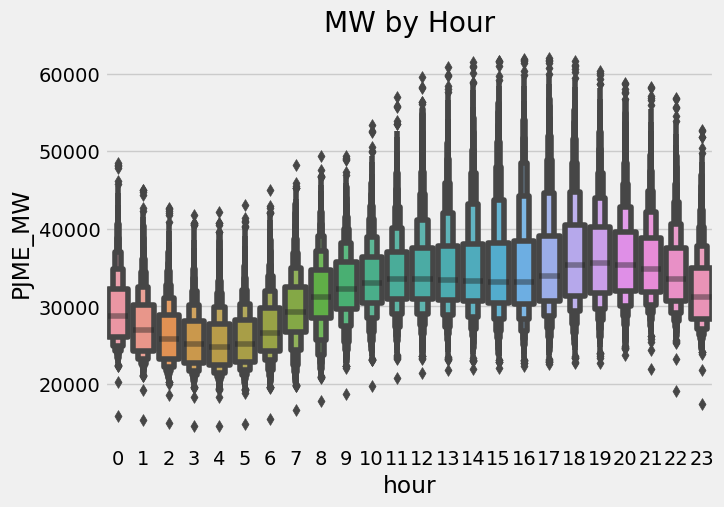

In [60]:
fig,ax=plt.subplots(figsize=(7,5))
sns.boxenplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

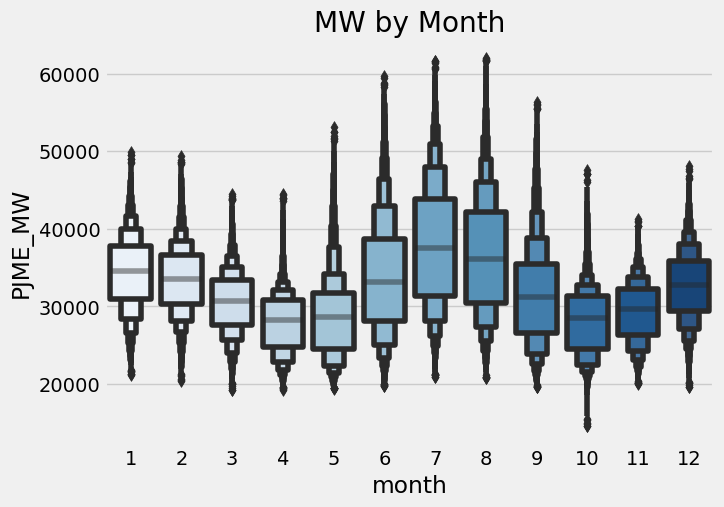

In [61]:
fig,ax=plt.subplots(figsize=(7,5))
sns.boxenplot(data=df,x='month',y='PJME_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Model

In [65]:

train=feature_creator(train)
test=feature_creator(test)

In [66]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayodyear'],
      dtype='object')

In [67]:
FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year','dayodyear']
TARGET='PJME_MW'

In [68]:
X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]

In [70]:
reg= xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

In [73]:
fi=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

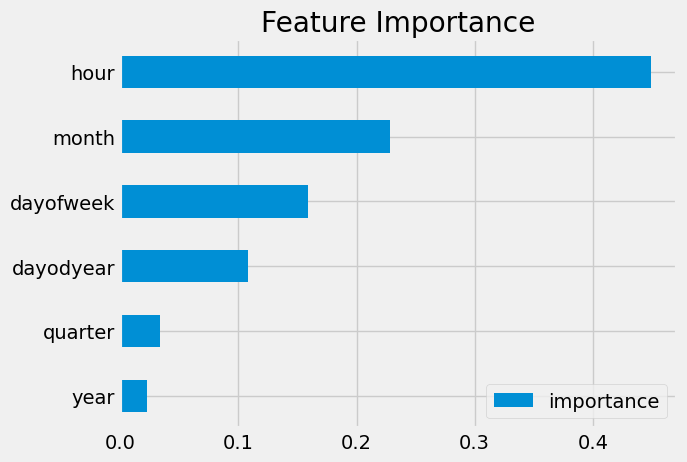

In [74]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')

# Forecast on Test

In [75]:
test['prediction']=reg.predict(X_test)

In [78]:
df=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

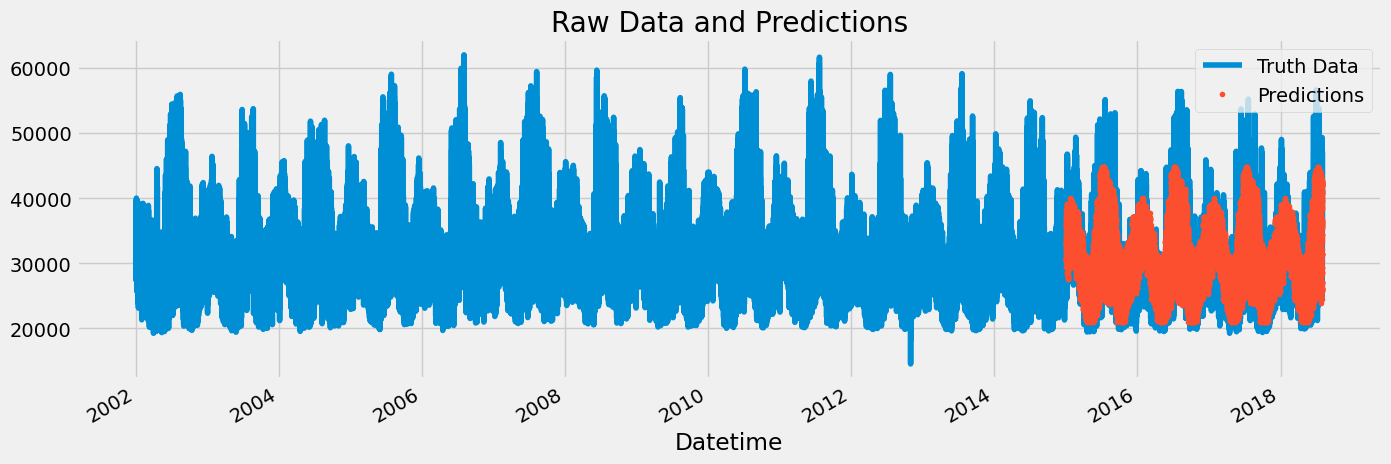

In [80]:
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

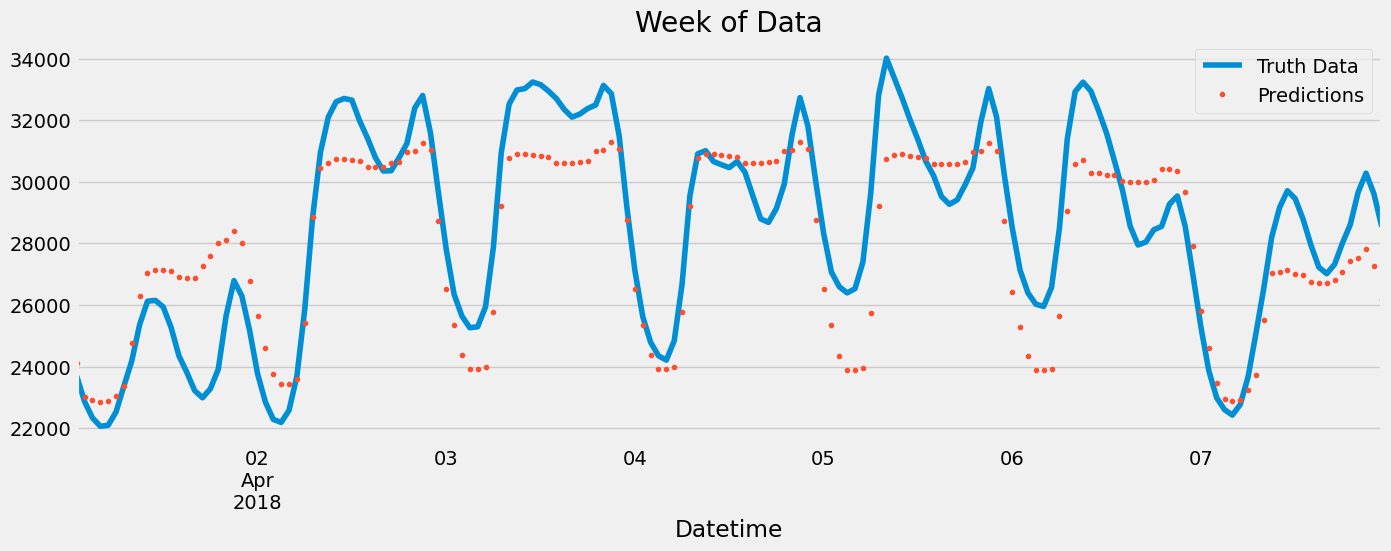

In [86]:
ax=df.loc[(df.index >'04-01-2018') & (df.index <'04-08-2018')]['PJME_MW'].plot(title='Week of Data',figsize=(15,5))
df.loc[(df.index >'04-01-2018') & (df.index <'04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Predictions'])
plt.show()

In [89]:
score=np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score on Test Set: {score:0.2f}')

RMSE Score on Test Set: 3715.93


# Calculate Error

In [90]:
test['error']=np.abs(test[TARGET]-test['prediction'])

In [91]:
test['date']=test.index.date

In [97]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

We can see that the worst predictions were made in the middle of August 2016

In [98]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

Best predictions were also made in 2016

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# Outlier Removal

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

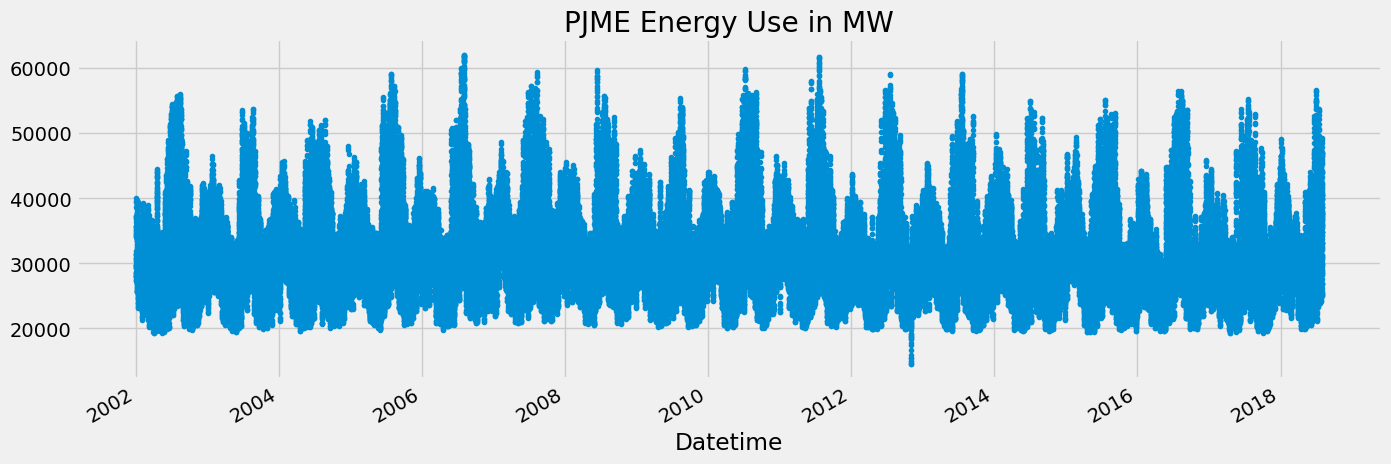

In [116]:

df=pd.read_csv('PJME_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)
df['PJME_MW'].plot(style='.',figsize=(15,5),title='PJME Energy Use in MW')

<Axes: ylabel='Frequency'>

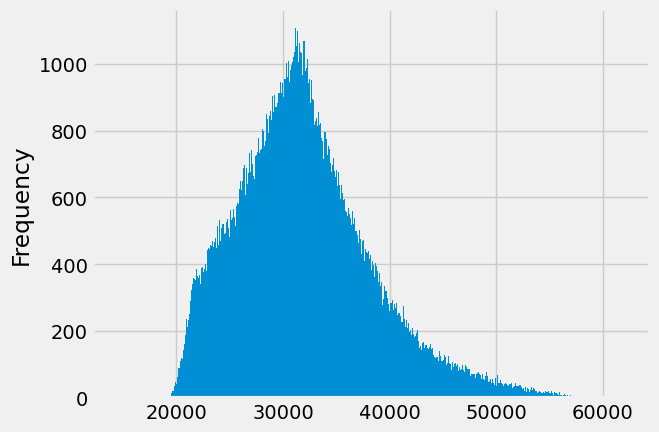

In [117]:
df['PJME_MW'].plot(kind='hist',bins=500)

<Axes: xlabel='Datetime'>

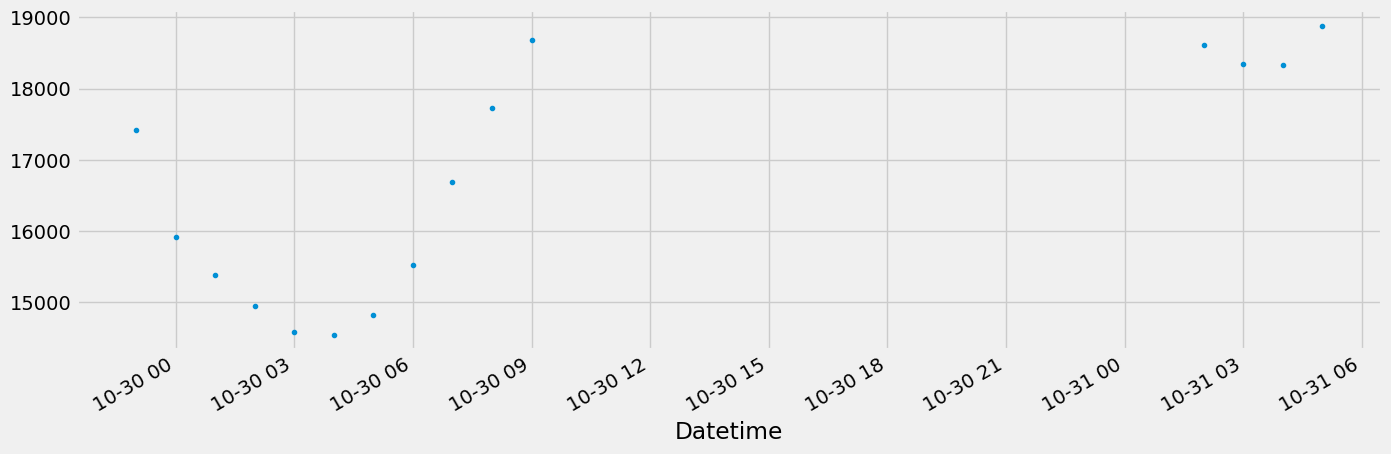

In [118]:
df['PJME_MW'].loc[df['PJME_MW']<19000].plot(figsize=(15,5),style='.')

In [119]:
df=df.query('PJME_MW > 19_000').copy()

# Time Series Cross Validation

In [120]:
from sklearn.model_selection import TimeSeriesSplit

In [121]:
tss=TimeSeriesSplit(n_splits=5,test_size=24*365*1,gap=24)
df=df.sort_index()

In [ ]:
def feature_creator(df):
    """
    Create time series features based on time series index.
    """
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayodyear']=df.index.day_of_year
    return df
df=feature_creator(df)

In [ ]:
def lag_features_creator(df):
    """
    Create lag features from time series data.
    """
    df=df.copy()
    target_map=df['PJME_MW'].to_dict()
    df['lag_1']=(df.index -pd.Timedelta('364 days')).map(target_map)
    df['lag_2']=(df.index -pd.Timedelta('728 days')).map(target_map)
    df['lag_3']=(df.index -pd.Timedelta('1092 days')).map(target_map)
    return df
df=lag_features_creator(df)

[18:15:56] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[457]	validation_0-rmse:3348.29869	validation_1-rmse:3761.08467
[18:16:17] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:5649.54800
[300]	validation_0-rmse:3909.18294	validation_1-rmse:3930.98277
[400]	

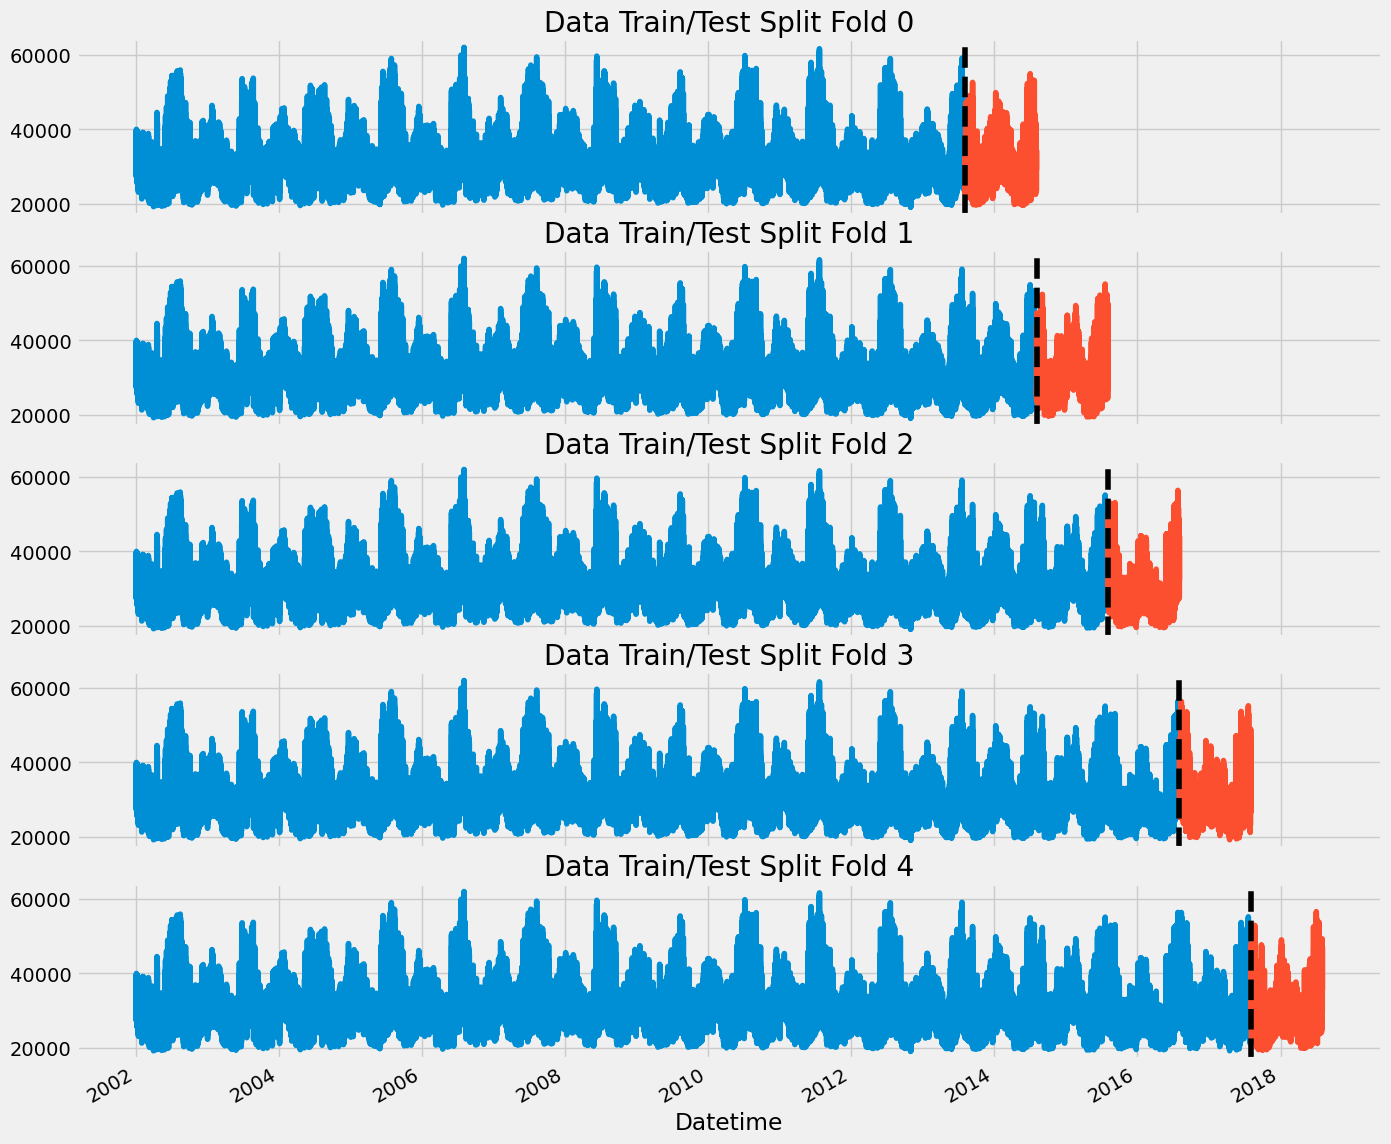

In [130]:
fig,axs=plt.subplots(5,1,figsize=(15,15),sharex=True)
fold=0
scores=[]
preds=[]
for train_idx,val_idx in tss.split(df):

    train=df.iloc[train_idx]
    test=df.iloc[val_idx]

    train=feature_creator(train)
    test=feature_creator(test)

    FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year','dayodyear','lag_1','lag_2','lag_3']
    TARGET='PJME_MW'

    X_train=train[FEATURES]
    y_train=train[TARGET]

    X_test=test[FEATURES]
    y_test=test[TARGET]

    reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree',
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)
    reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=100)
    y_pred=reg.predict(X_test)
    preds.append(y_pred)
    score=np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold+=1
plt.show()

In [131]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds 3750.7137
Fold scores: [3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.7260445492084, 3996.298054855067]


# Predicting the Future
- Retraining all the data.
- To predict the future we need an empty dataframe for future date ranges.
- Run those dates through our feature creation + lag creation.

In [132]:
df=feature_creator(df)
df=lag_features_creator(df)

FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year','dayodyear','lag_1','lag_2','lag_3']
TARGET='PJME_MW'

X_all=df[FEATURES]
y_all=df[TARGET]

reg=xgb.XGBRegressor(base_score=0.5,booster='gbtree',
                         n_estimators=500,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)
reg.fit(X_all,y_all,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=100)

[18:28:48] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32462.32963	validation_1-rmse:31463.98625
[100]	validation_0-rmse:12455.77271	validation_1-rmse:11951.66764
[200]	validation_0-rmse:5762.85573	validation_1-rmse:5588.04795
[300]	validation_0-rmse:3963.92304	validation_1-rmse:4064.99565
[400]	validation_0-rmse:3553.02520	validation_1-rmse:3816.67874
[499]	validation_0-rmse:3433.67363	validation_1-rmse:3766.99971


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

                     hour  dayofweek  quarter  month  year  dayodyear  \
Datetime                                                                
2002-01-01 01:00:00     1          1        1      1  2002          1   
2002-01-01 02:00:00     2          1        1      1  2002          1   
2002-01-01 03:00:00     3          1        1      1  2002          1   
2002-01-01 04:00:00     4          1        1      1  2002          1   
2002-01-01 05:00:00     5          1        1      1  2002          1   
...                   ...        ...      ...    ...   ...        ...   
2018-08-02 20:00:00    20          3        3      8  2018        214   
2018-08-02 21:00:00    21          3        3      8  2018        214   
2018-08-02 22:00:00    22          3        3      8  2018        214   
2018-08-02 23:00:00    23          3        3      8  2018        214   
2018-08-03 00:00:00     0          4        3      8  2018        215   

                       lag_1    lag_2    lag_3  
D

In [136]:
future=pd.date_range(start='2018-08-03 00:00:00',end='2019-08-03 00:00:00',freq='1h')
future_df=pd.DataFrame(index=future)
future_df['isFuture']= True
df['isFuture']=False
df_and_future=pd.concat([df,future_df])

In [138]:
df_and_future=feature_creator(df_and_future)
df_and_future=lag_features_creator(df_and_future)

In [140]:
future_w_features=df_and_future.query('isFuture').copy()
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayodyear,lag_1,lag_2,lag_3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,20,4,3,8,2019,214,NaN,43606.0,40513.0,True
2019-08-02 21:00:00,NaN,21,4,3,8,2019,214,NaN,41863.0,39840.0,True
2019-08-02 22:00:00,NaN,22,4,3,8,2019,214,NaN,40005.0,38664.0,True
2019-08-02 23:00:00,NaN,23,4,3,8,2019,214,NaN,37174.0,36125.0,True


In [141]:
future_w_features['pred']=reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

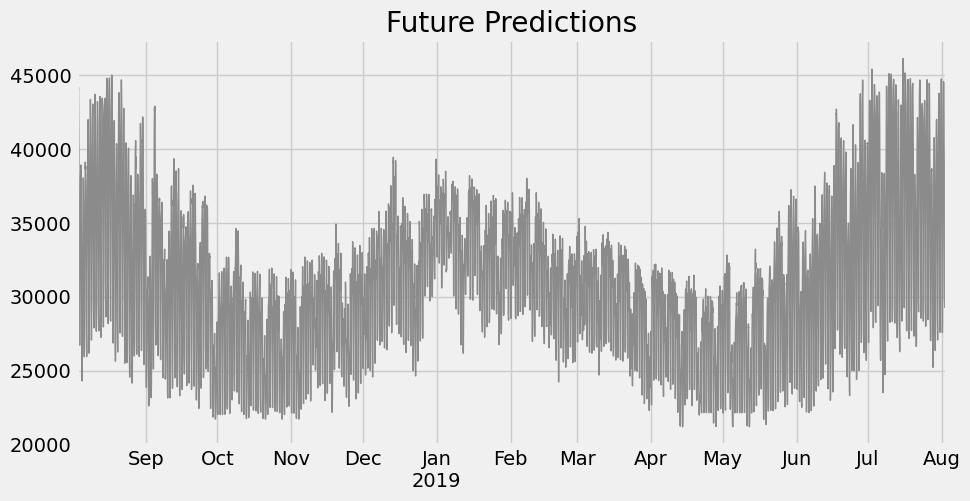

In [142]:
future_w_features['pred'].plot(figsize=(10,5),color=color_pal[4],ms=1,lw=1,title='Future Predictions')

In [143]:
reg.save_model('XGBReg_energy_predictor.json')